# Tutorial 1A: DDPM
A diffusion model requires a UNet to process the input and produce the output at each step.

In [1]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=128,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

print(model)

c:\Users\gertl\Repos\MSGAI24\.venv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

For training a diffusion model, in each iteration, we need a random noise which will be added to the training sample image. Note that we could also do batched training, but for this course we always assume batch size=1.

In [2]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

# fake training sample image, you can load your own
sample_image = torch.randn([1, 3, 128, 128])

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
# in each training iteration, sample a 't' value.
# here we use 50 as an example
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

The training objective of the model is to predict the noise added to the image. The loss at this step can be calculated by:

In [3]:
import torch.nn.functional as F
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(f"Loss: {loss.item()}")

Loss: 1.130186676979065


The training of a diffusion model is very time-consuming. If you are interested in training a diffusion model from scratch by yourself, please refer to https://huggingface.co/docs/diffusers/en/tutorials/basic_training.
DDPMPipeline can be applied to sample synthetic images according to the trained unet and the model configuration.

c:\Users\gertl\Repos\MSGAI24\.venv2\Lib\site-packages\diffusers\configuration_utils.py:248: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


Using device: cuda


100%|██████████| 1000/1000 [00:52<00:00, 18.89it/s]


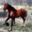

In [4]:
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from IPython.display import display

# google/ddpm-cifar10    google/ddpm-church-256
repo_id = "google/ddpm-cifar10"

# loading a pretrained unet
unet = UNet2DModel.from_pretrained(repo_id)
# loading the corresponding training configuration
scheduler = DDPMScheduler.from_config(repo_id)

ddpm_pipe = DDPMPipeline(unet, scheduler)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
ddpm_pipe.to(device)
res = ddpm_pipe()
image = res.images[0]

display(image)

We can also do the sampling step by step using the following code.

Using device: cuda
torch.Size([1, 3, 32, 32])
Denoising for 1000 timesteps...


'Image at step 100'

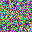

'Image at step 200'

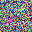

'Image at step 300'

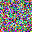

'Image at step 400'

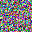

'Image at step 500'

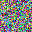

'Image at step 600'

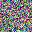

'Image at step 700'

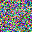

'Image at step 800'

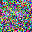

'Image at step 900'

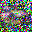

'Image at step 1000'

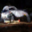

In [6]:
import PIL.Image
import numpy as np
import torch

def display_sample(sample, i):
    image_processed=sample.cpu().permute(0,2,3,1)
    image_processed=(image_processed+1.0)*127.5
    image_processed=image_processed.numpy().astype(np.uint8)
    image_pil=PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
unet.to(device)
scheduler.timesteps = scheduler.timesteps.to(device)

noisy_sample=torch.randn(1, unet.config.in_channels, unet.config.sample_size,
                         unet.config.sample_size).to(device)

print(noisy_sample.shape)

sample=noisy_sample

print(f"Denoising for {len(scheduler.timesteps)} timesteps...")
for i, t in enumerate(scheduler.timesteps):
    # t is already on the correct device now
    with torch.no_grad():
        residual=unet(sample,t).sample

    # compute less noisy image and set x_t -> x_t-1
    sample =scheduler.step(residual, t, sample).prev_sample

    if (i+1)%100==0:
        display_sample(sample, i+1)

# Tutorial 1B: Latent Diffusion

### Using latent diffusion models to generate images according to text description.
Latent diffusion is applied to sample high-resolution images. An autoencoder is utilized to reduce the dimension of the input images for accelerating the sampling.

Keyword arguments {'trust_remote_code': True} are not expected by LDMTextToImagePipeline and will be ignored.
100%|██████████| 50/50 [00:08<00:00,  6.12it/s]


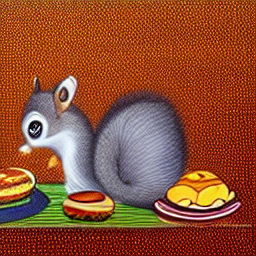

In [ ]:
from diffusers import DiffusionPipeline
from IPython.display import display
import transformers.utils.import_utils

# Temporarily disable the torch version check (for educational purposes only), otherwise newer
# torch versions may not be compatible with older models.
transformers.utils.import_utils.is_torch_greater_or_equal = lambda x: True

# Use the model without safetensors and allow pickle loading
ldm = DiffusionPipeline.from_pretrained(
    "CompVis/ldm-text2im-large-256",
    use_safetensors=False,
    trust_remote_code=True,
    local_files_only=False
).to(device)
prompt = "A painting of a squirrel eating a burger"
images = ldm([prompt], num_inference_steps=50, eta=0.3, guidance_scale=6).images

display(images[0])

In [ ]:
prompt = "A dog is running"
images = ldm([prompt], num_inference_steps=50, eta=0.3, guidance_scale=6).images

display(images[0])

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/50 [00:00<?, ?it/s]

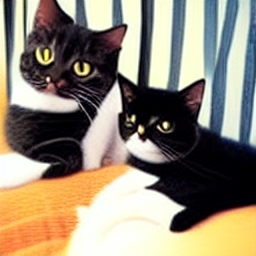

In [ ]:
prompt = "Two lovely cats"
images = ldm([prompt], num_inference_steps=50, eta=0.3, guidance_scale=6).images

display(images[0])

### Defining a latent diffusion model step by step

In [ ]:
# You'll need to install scipy for the following part
# You can use pip install scipy or conda install scipy -y



Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -y


In [ ]:
import torch, logging

## disable warnings
logging.disable(logging.WARNING)

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms

## Basic libraries
import numpy as np
from tqdm.auto import tqdm

## Import the CLIP artifacts
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from IPython.display import display, clear_output
import os

dtype = torch.float16 if torch.cuda.is_available() else torch.float

In [ ]:
## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype).to(device)

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=dtype).to(device)

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=dtype).to(device)

In [ ]:
def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device=device, dtype=torch.float16)
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual prompt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to(device))[0].to(dtype)


In [ ]:

def prompt_2_img(prompts, g=7.5, seed=100, steps=70, dim=512, save_int=True):
    """
    Diffusion process to convert prompt to image
    """
    bs = len(prompts)

    # prompt → embeddings
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])

    if seed:
        torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
    scheduler.set_timesteps(steps)
    latents = latents.to(device=device, dtype=dtype) * scheduler.init_noise_sigma

    # Prepare tqdm
    pbar = tqdm(
        iterable=list(scheduler.timesteps),
        total=steps,
        desc="Denoising",
        dynamic_ncols=True
    )
    
    print(f"Starting diffusion with {steps} steps on device {device}...")

    for i, ts in enumerate(pbar, start=1):
        # scale & predict
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad():
            u, t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        pred = u + g * (t - u) # Guidance
        latents = scheduler.step(pred, ts, latents).prev_sample

        # compute norm & update bar
        latents_norm = torch.norm(latents.view(bs, -1), dim=1).mean().item()
        pbar.set_postfix(step=i, latents_norm=f"{latents_norm:.4f}")

        # optionally save/display intermediates
        if save_int and i % 10 == 0:
            img = latents_to_pil(latents)[0]
            path = f'steps2/la_{i:04d}.jpeg'
            img.save(path)
            from IPython.display import display, clear_output
            clear_output(wait=True)
            display(img)

    return latents_to_pil(latents)

In [ ]:
images = prompt_2_img(["A dog wearing a hat"], save_int=False)
import time 
start_time = time.time()
for img in images:
    display(img)

print(f"That took {time.time() - start_time:.2f} seconds to generate, there must be a faster way to do this!")

C:\Users\gertl\AppData\Local\Temp\ipykernel_19676\901484811.py:15: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


Denoising:   0%|          | 0/70 [00:00<?, ?it/s]

Starting diffusion with 70 steps on device cuda...
